**Remaining Probelems updated 0612**
- solve bounded in section 3
- solve equilibrium (w,r) in section 1 by nested bisection

Section 3 tips
- 可以进一步变形为线性-非线性不等式
- 非线性部分严格增、严格凹函数 CD type
- 求解有几种情况：有解(取其大者)/无解(对应无法借钱，无法创业)；如果有解进一步用KKT条件与全局最优比较
- 求解的代码！！！！！！！

Section 4 tips
- nested-nested bisection   given p_s,r , solve w , then for all r

验证：制造业的出清

边做边测试，不然就无敌了

add grid to 200*40

# section one

## Setup

In [2]:
# parameters setting

# tech
alpha=0.3
theta=0.49
fc_m=4.68
fc_s=0

# depreciation
delta=0.06

# describing the process for entrepreneurial talent
gamma=0.89
eta=4.84

# discount factor
beta=0.92

# relative risk aversion
sigma=1.5

# intratemporal elasticity of substitution
epsilon=1

# service share in consumption
psi=0.91

In [3]:
# import packages
import timeit
import numpy as np
from numba import njit,prange
import numba
import matplotlib.pyplot as plt

In [4]:
# talent probability
from scipy.stats import pareto
def discrete_pareto(shape,lower_bound,upper_bound,grid_numder):
    ability=np.linspace(pareto.ppf(lower_bound,shape),pareto.ppf(upper_bound,shape),(grid_numder+1))  # 可以从60%开始取点，但是没改全！！！
    probability=np.diff(pareto.cdf(ability,shape)) / (upper_bound-lower_bound)
    zgrid = ability[1:]
    return zgrid,probability

In [5]:
# add kgrid to 250
kmin = 0
kmax = 150
n_k = 250
kgrid = np.linspace(kmin, kmax, n_k)
zgrid,p_z = discrete_pareto(4.84,0.6,0.995,40)
n_z = len(zgrid)
V0 = np.zeros((n_k, n_z))
P=np.zeros((n_z, n_z))
for i in range(n_z):
    for j in range(n_z):
        if j==i:
            P[i,j]=gamma+(1-gamma)*p_z[j]
        else:
            P[i,j]=(1-gamma)*p_z[j]

In [6]:
def u(c):
    if c > 0:
        res = (c**(1-sigma))/(1-sigma)
    else:
        res = -np.inf
    return res
if compile:
    u = njit(u)
    
def budget_worker(a, x, w, r):
    return w + (1+r)*a - x
if compile:
    budget_worker = njit(budget_worker)
    
def budget_entrepreneur(z_index, k, l, a , x , w, r):
    R = r + delta
    return zgrid[z_index]*(k**alpha)*(l**theta) + (1+r)*a - R*k - w*l - x
if compile:
    budget_entrepreneur = njit(budget_entrepreneur)

In [7]:
## Vmax Vupdate 合并 整体优化
## parallel prange  优化  done
## 最终结果能到毫秒级 
## model4 0.5 s


def V_current_worker(k_next_index, k_index, z_index, V_next, w, r):
    c = budget_worker(kgrid[k_index], kgrid[k_next_index], w, r)
    EV = np.sum(P[z_index,:]*V_next[k_next_index,:]) # expectation
    res = u(c) + beta*(gamma*V_next[k_next_index,z_index]+(1-gamma)*EV)
    return res
if compile:
    V_current_worker = njit(V_current_worker)
    
def V_max_worker(k_index, z_index, k_start, V, w, r):
    V_max = -np.inf
    for j in range(k_start,n_k):
        k_next = kgrid[j]
        V_new=V_current_worker(j,k_index,z_index, V, w, r)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:break
    return V_max, g_k, k_start
if compile:
    V_max_worker = njit(V_max_worker)

def V_update_worker(V, w, r):
    V_new = np.zeros((n_k, n_z))
    g_new = np.zeros((n_k, n_z))
    for i_z in prange(n_z): 
        k_start = 0
        for i_k in range(n_k): # loop over all state k
            V_new[i_k, i_z], g_new[i_k, i_z] ,k_start= V_max_worker(i_k, i_z,k_start,V,w,r)
    return V_new, g_new
if compile:
    V_update_worker = njit(V_update_worker, parallel=True)

def together_V_update_worker(V, w, r):
    V_newer = np.zeros((n_k, n_z))
    g_newer = np.zeros((n_k, n_z))
    for i_z in prange(n_z): 
        k_start = 0
        for i_k in range(n_k): # loop over all state k
            V_max = -np.inf
            for j in range(k_start,n_k):
                k_next = kgrid[j]
                V_new=V_current_worker(j,i_k,i_z, V, w, r)
                if V_new > V_max:
                    V_max = V_new
                    g_k = k_next
                    k_start = j
                else:break
            V_newer[i_k, i_z] = V_max
            g_newer[i_k, i_z] = g_k
    return V_newer, g_newer
if compile:
    together_V_update_worker = njit(together_V_update_worker, parallel=True)

In [8]:

def V_current_entrepreneur(k_next_index, k_index, z_index, V_next, k, l, w, r):
    c = budget_entrepreneur(z_index, k, l, kgrid[k_index], kgrid[k_next_index], w, r)
    EV = np.sum(P[z_index,:]*V_next[k_next_index,:]) # expectation
    res = u(c) + beta*(gamma*V_next[k_next_index,z_index]+(1-gamma)*EV)
    return res
if compile:
    V_current_entrepreneur = njit(V_current_entrepreneur)

def V_max_entrepreneur(k_index, z_index, k_start, V ,w, r):
    # R=r+delta
    k=(((r+delta)/alpha/zgrid[z_index])*(w*alpha/(r+delta)/theta)**theta)**(1/(alpha+theta-1))
    l=k*(theta/alpha)*((r+delta)/w)
    V_max = -np.inf
    for j in range(k_start,n_k):
        k_next = kgrid[j]
        V_new=V_current_entrepreneur(j,k_index,z_index, V, k,l,w, r)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:break
    return V_max, g_k, k_start
if compile:
    V_max_entrepreneur = njit(V_max_entrepreneur)

def V_update_entrepreneur(V, w, r): # 冗余了
    V_new = np.zeros((n_k, n_z))
    g_new = np.zeros((n_k, n_z))
    for i_z in prange(n_z): 
        k_start = 0
        for i_k in range(n_k): # loop over all state k
            V_new[i_k, i_z], g_new[i_k, i_z] ,k_start= V_max_entrepreneur(i_k, i_z,k_start, V, w, r)
    return V_new, g_new
if compile:
    V_update_entrepreneur = njit(V_update_entrepreneur, parallel=True)

def together_V_update_entrepreneur(V, w, r):
    V_newer = np.zeros((n_k, n_z))
    g_newer = np.zeros((n_k, n_z))
    for i_z in prange(n_z): 
        k_start = 0
        for i_k in range(n_k): # loop over all state k
            V_max = -np.inf
            k=(((r+delta)/alpha/zgrid[i_z])*(w*alpha/(r+delta)/theta)**theta)**(1/(alpha+theta-1))
            l=k*(theta/alpha)*((r+delta)/w)
            for j in range(k_start,n_k):
                k_next = kgrid[j]
                V_new=V_current_entrepreneur(j,i_k,i_z, V, k,l,w, r)
                if V_new > V_max:
                    V_max = V_new
                    g_k = k_next
                    k_start = j
                else:break
            V_newer[i_k, i_z] = V_max
            g_newer[i_k, i_z] = g_k
    return V_newer, g_newer
if compile:
    together_V_update_entrepreneur = njit(together_V_update_entrepreneur, parallel=True)

## workers only

In [9]:
def V_iteration_worker(V_initial,tol,w,r):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        V_new, g_new = V_update_worker(V,w,r)
        error = np.max(np.abs(V_new - V))
        V = V_new
        count = count + 1
        if count % print_skip == 0:
            print(f"Error at iteration {count} is {error}.")
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return V_new, g_new

start_time = timeit.default_timer()
V_worker, g_worker = V_iteration_worker(V0,tol=1e-7,w=0.9,r=0.05)
print("The time difference is :", timeit.default_timer() - start_time)

Error at iteration 50 is 0.03544151522072525.
Error at iteration 100 is 0.0005481553386204041.
Error at iteration 150 is 8.478031311653922e-06.
Error at iteration 200 is 1.3112528307601679e-07.

Converged in 204 iterations.
The time difference is : 4.032934699964244


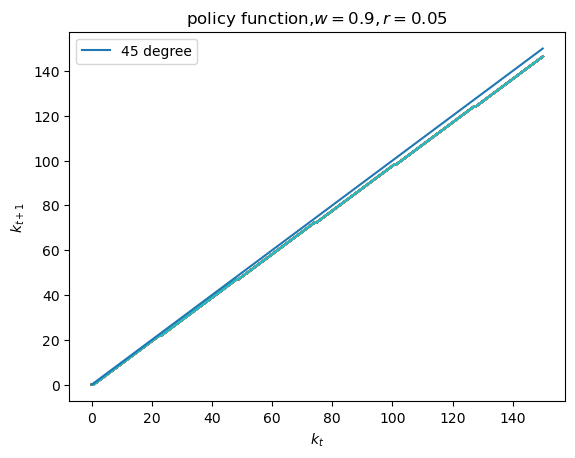

In [10]:
for i in range (40):
    plt.plot(kgrid,g_worker[:,i])
plt.plot(kgrid,kgrid,label="45 degree")
plt.xlabel("$k_t$")
plt.ylabel("$k_{t+1}$")
plt.title('policy function,$w=0.9,r=0.05$')
plt.legend()

Text(0.5, 1.0, 'value function,$w=0.9,r=0.05$')

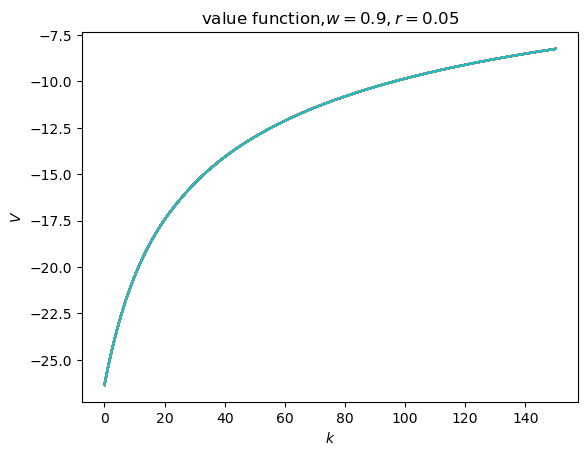

In [11]:
for i in range (40):
    plt.plot(kgrid,V_worker[:,i])
plt.xlabel("$k$")
plt.ylabel("$V$")
plt.title('value function,$w=0.9,r=0.05$')


## entrepreneurs only

In [12]:
def V_iteration_entrepreneur(V_initial,tol,w,r):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        V_new, g_new = V_update_entrepreneur(V,w,r)
        error = np.max(np.abs(V_new - V))
        V = V_new
        count = count + 1
        if count % print_skip == 0:
            print(f"Error at iteration {count} is {error}.")
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return V_new, g_new

start_time = timeit.default_timer()
V_entrepreneur, g_entrepreneur = V_iteration_entrepreneur(V0,tol=1e-7,w=0.9,r=0.05)
print("The time difference is :", timeit.default_timer() - start_time)

Error at iteration 50 is 0.036966787065470186.
Error at iteration 100 is 0.0005221952029330623.
Error at iteration 150 is 7.656450016213512e-06.
Error at iteration 200 is 1.1488021911532087e-07.

Converged in 202 iterations.
The time difference is : 2.918683100026101


Text(0.5, 1.0, 'policy function,$w=0.9,r=0.05$')

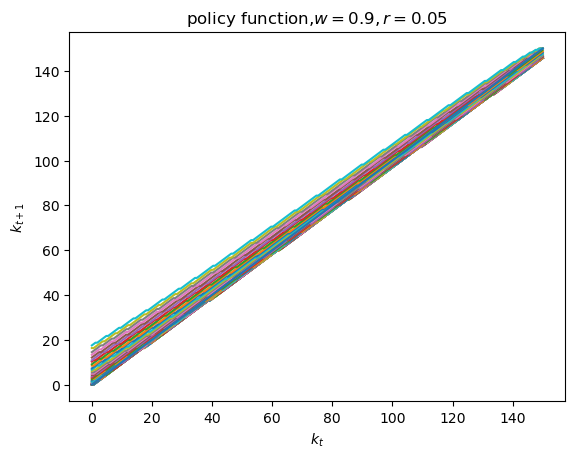

In [13]:

for i in range (40):
    plt.plot(kgrid,g_entrepreneur[:,i],label='z='+ str(zgrid[i]))
plt.plot(kgrid,kgrid,label="45 degree")
plt.xlabel("$k_t$")
plt.ylabel("$k_{t+1}$")
plt.title('policy function,$w=0.9,r=0.05$')


Text(0.5, 1.0, 'value function,$w=0.9,r=0.05$')

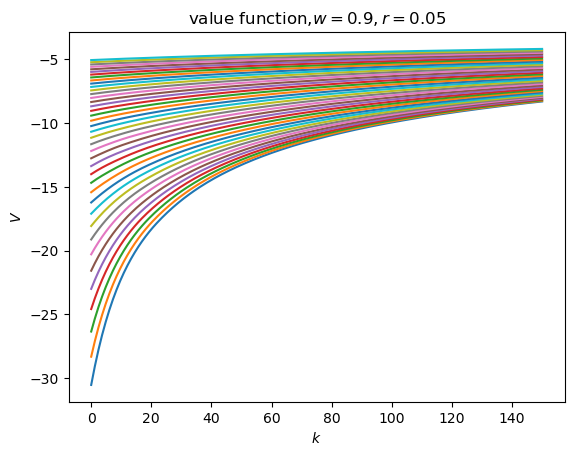

In [14]:
for i in range (40):
    plt.plot(kgrid,V_entrepreneur[:,i],label='z='+ str(zgrid[i]))
plt.xlabel("$k$")
plt.ylabel("$V$")
plt.title('value function,$w=0.9,r=0.05$')

## plot together

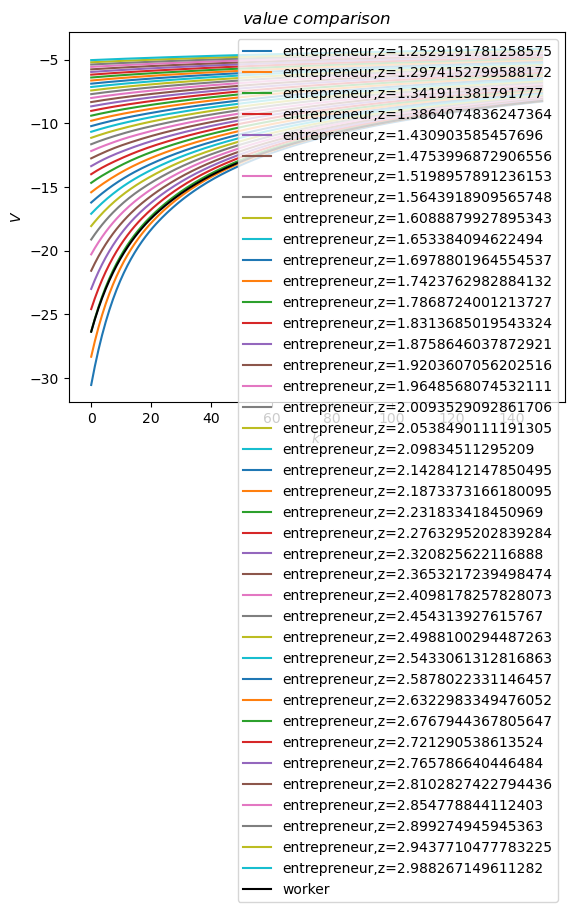

In [15]:
for i in range (40):
    plt.plot(kgrid,V_entrepreneur[:,i],'-',label='entrepreneur,z='+ str(zgrid[i]))
plt.plot(kgrid,V_worker[:,0],color='black',label='worker')
plt.xlabel("$k$")
plt.ylabel("$V$")
plt.title('$value \ comparison$')
plt.legend()

## iterate together

In [16]:
def V_update(V, w, r): # 放到一起
    V_new = np.zeros((n_k, n_z))
    g_new = np.zeros((n_k, n_z))
    state_new = np.zeros((n_k, n_z))
    # V_worker,g_worker=V_update_worker(V, w, r)
    # V_entrepreneur,g_entrepreneur=V_update_entrepreneur(V, w, r)
    for i_z in prange(n_z):
        k_start_worker=0
        k_start_entrepreneur=0
        for i_k in range(n_k):
            V_new_worker, g_new_worker,k_start_worker= V_max_worker(i_k, i_z,k_start_worker,V,w,r)
            V_new_entrepreneur, g_new_entrepreneur,k_start_entrepreneur= V_max_entrepreneur(i_k, i_z,k_start_entrepreneur,V,w,r)
            if V_new_worker>=V_new_entrepreneur:
                V_new[i_k, i_z]=V_new_worker
                g_new[i_k, i_z]=g_new_worker
            else:
                V_new[i_k, i_z]=V_new_entrepreneur
                g_new[i_k, i_z]=g_new_entrepreneur
                state_new[i_k, i_z]=1
    return V_new, g_new, state_new
if compile:
    V_update = njit(V_update,parallel=True)


def V_iteration(V_initial,tol,w,r):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    # print_skip = 50
    while count < max_iter and error > tol:
        V_new, g_new, state_new = V_update(V, w, r)
        error = np.max(np.abs(V_new - V))
        V = V_new
        count = count + 1
        # if count % print_skip == 0:
        #     print(f"Error at iteration {count} is {error}.")
    # if error > tol:
    #     print("Failed to converge!")
    # else:
    #      print(f"\nConverged in {count} iterations.")
    return V_new, g_new, state_new

In [17]:
%%time

V_update(V0,0.9,0.05)

CPU times: total: 1.09 s
Wall time: 1.07 s


(array([[-2.10818511, -2.10818511, -2.10818511, ..., -0.34359811,
         -0.3313612 , -0.319734  ],
        [-1.61556891, -1.61556891, -1.61556891, ..., -0.340435  ,
         -0.32852142, -0.31718053],
        [-1.35923642, -1.35923642, -1.35923642, ..., -0.33735768,
         -0.32575342, -0.31468728],
        ...,
        [-0.15954883, -0.15954883, -0.15954883, ..., -0.14505093,
         -0.14408836, -0.14309005],
        [-0.15922867, -0.15922867, -0.15922867, ..., -0.14481024,
         -0.14385241, -0.14285897],
        [-0.15891043, -0.15891043, -0.15891043, ..., -0.14457073,
         -0.14361762, -0.142629  ]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
       

In [18]:
start_time = timeit.default_timer()
V, g , state_entrepreneur= V_iteration(V0,tol=1e-7,w=0.9,r=0.05 )
print("The time difference is :", timeit.default_timer() - start_time)

The time difference is : 1.0104446000186726


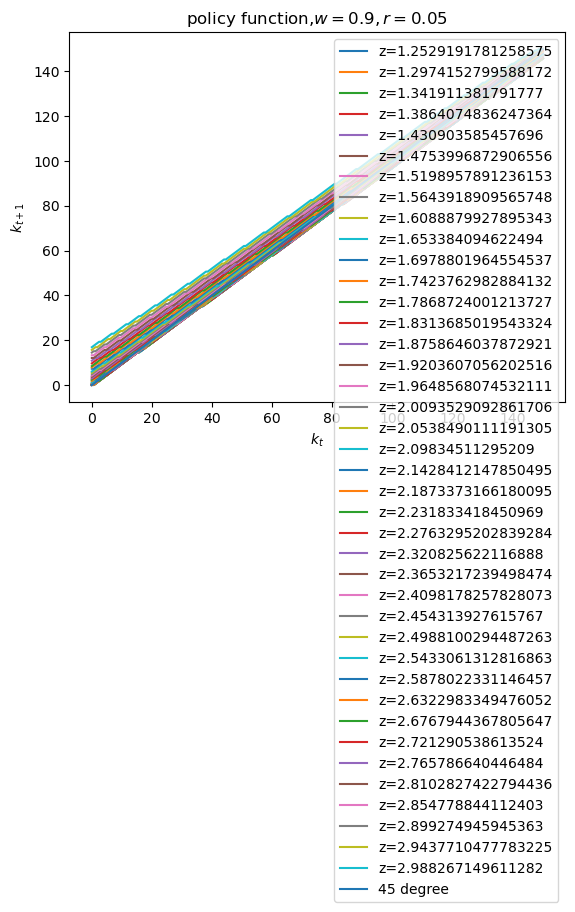

In [19]:
for i in range (40):
    plt.plot(kgrid,g[:,i],label='z='+ str(zgrid[i]))
plt.plot(kgrid,kgrid,label="45 degree")
plt.xlabel("$k_t$")
plt.ylabel("$k_{t+1}$")
plt.title('policy function,$w=0.9,r=0.05$')
plt.legend()

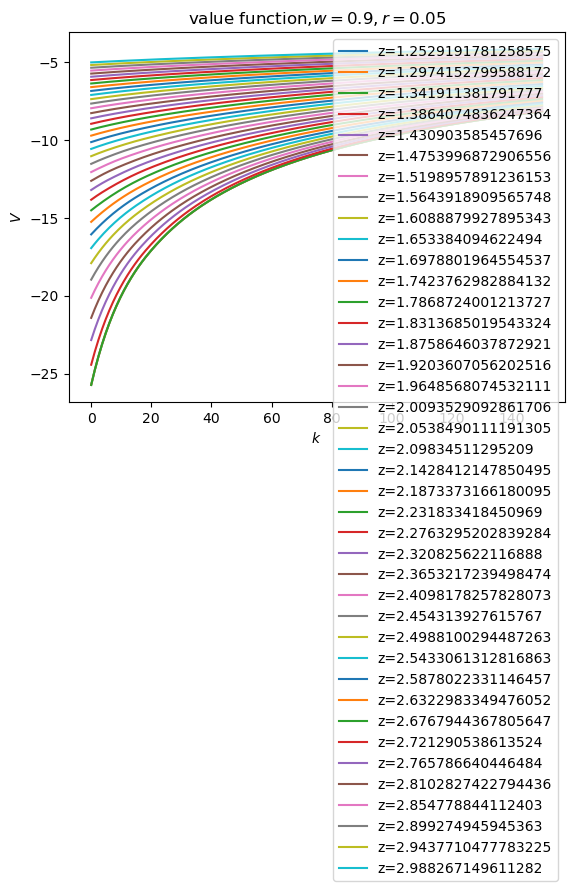

In [20]:
for i in range (40):
    plt.plot(kgrid,V[:,i],label='z='+ str(zgrid[i]))
plt.xlabel("$k$")
plt.ylabel("$V$")
plt.title('value function,$w=0.9,r=0.05$')
plt.legend()

In [21]:
state_entrepreneur

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [22]:
np.sum(state_entrepreneur)

9250.0

In [23]:

from scipy import sparse

def transQ_sparse(g):
    n_k, n_s = g.shape
    n = n_k * n_s
    row_indices = []
    col_indices = []
    values = []

    for j in numba.prange(n):
        i_k = j // n_s
        i_s = j % n_s
        diff = np.abs(g[i_k, i_s] - kgrid)
        mark = np.argmin(diff)
        j_prime_start = mark * n_s
        
        row = np.full(n_s, j)
        col = np.arange(j_prime_start, j_prime_start + n_s)
        val = P[i_s, :]
        
        row_indices.extend(row)
        col_indices.extend(col)
        values.extend(val)

    Q = sparse.csr_matrix((values, (row_indices, col_indices)), shape=(n, n))
    return Q

In [24]:
# Asset's Stable Distribution
def transQ(g):
    n_k, n_z = g.shape
    n = n_k * n_z
    Q = np.zeros((n, n))
    for j in numba.prange(n):
        i_k = j // n_z
        i_s = j % n_z
        diff = np.abs(g[i_k, i_s] - kgrid)
        mark = np.argmin(diff)
        j_prime_start = mark * n_z
        j_prime_end = j_prime_start + n_z
        Q[j, j_prime_start:j_prime_end] = P[i_s, :]
    return Q

# def stationary_distribution(Q):
#     from scipy.sparse.linalg import eigs
#     k = 1 
#     eigenvalues, eigenvectors = eigs(Q.T, k=k, which='LM')  
#     index = np.argmin(np.abs(np.abs(eigenvalues)-1.0))
#     stationary_vector = np.real(eigenvectors[:, index])
#     stationary_distribution = stationary_vector / np.sum(stationary_vector)
#     return stationary_distribution
# 可以试一下迭代的方法，效率会高(乘法的计算快于求逆)


def capital_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_z))
    k_marginal = tmp.sum(axis=1)
    return k_marginal

def state_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_z))
    s_marginal = tmp.sum(axis=0)
    return s_marginal

# 0是列(given z)，1是行(given k)

In [25]:
def pristine_stationary_distribution_iteration(P, psi0, tol):
    err = np.inf
    max_iter = 1000
    iter = 0
    print_skip = 500
    while iter < max_iter and err > tol:
        psi = np.dot(P.T,psi0)
        err = np.max(np.abs(psi - psi0))
        iter = iter + 1
        # if iter % print_skip == 0:
        #     print(f"Error at iteration {iter}:", err)
        #     print(np.sum(psi))
        psi0 = psi
    # if err > tol:
    #     print("Failed to converge!")
    # else:
    #     print(f"\nConverged in {iter} iterations.")
    return psi0


import scipy.sparse as sp

def sparse_stationary_distribution_iteration(P, psi0, tol):
    P_csc = sp.csc_matrix(P.T)
    err = np.inf
    max_iter = 1000
    iter = 0
    print_skip = 50
    
    while iter < max_iter and err > tol:
        psi = P_csc.dot(psi0)
        err = np.max(np.abs(psi - psi0))
        iter = iter + 1
        psi0 = psi
        
    return psi0


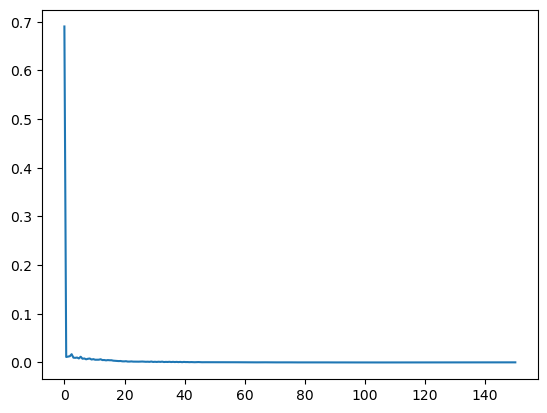

In [26]:
Q = transQ_sparse(g)
psi0 = np.ones((n_k * n_z))/(n_k * n_z)
tol = 1e-5

ss = sparse_stationary_distribution_iteration(Q, psi0, tol)
a_dist=capital_marginal(ss)
plt.plot(kgrid,a_dist)

In [27]:
# Compute Demand and Supply in Capital Market
def capital_and_labor(w,r):
    V0 = np.zeros((n_k, n_z))
    V_new,g,state_entrepreneur=V_iteration(V0,1e-7,w,r)
    Q=transQ_sparse(g)
    psi0 = np.ones((n_k * n_z))/(n_k * n_z)
    ss=sparse_stationary_distribution_iteration(Q,psi0,10e-5)
    # ss=stationary_distribution(Q)
    tmp = ss.reshape((n_k, n_z))
    a_dist=capital_marginal(ss)
    z_dist=state_marginal(ss)
## capital_supply
    capital_supply=np.dot(kgrid,a_dist)
## labor_supply
    state_worker=np.ones((n_k, n_z))-state_entrepreneur
    labor_supply_joint=np.zeros((n_k, n_z))            
## capital_demand & labor_demand
    R=r+delta
    capital_demand_joint= np.zeros((n_k, n_z))
    labor_demand_joint= np.zeros((n_k, n_z))
    for i_k in range(n_k):
        for i_z in range(n_z):
            capital_demand_joint[i_k,i_z]=state_entrepreneur[i_k,i_z]*((R/alpha/zgrid[i_z])*(w*alpha/R/theta)**theta)**(1/(alpha+theta-1))*tmp[i_k,i_z] 
            #capital_demand_joint 这里已经乘以概率了
            labor_demand_joint[i_k,i_z]=capital_demand_joint[i_k,i_z]*(theta/alpha)*(R/w)
            labor_supply_joint[i_k,i_z]=state_worker[i_k,i_z]*tmp[i_k,i_z]
    labor_supply=np.sum(labor_supply_joint)
    capital_demand=np.sum(capital_demand_joint)
    labor_demand=np.sum(labor_demand_joint)
    
    return capital_supply,capital_demand,labor_supply,labor_demand

In [28]:
capital_and_labor(0.9,0.05)

(5.493556838566059, 27.178993006692156, 0.4028130551351839, 5.425732307632249)

## solve equilibrium price $(w,r)$

how to realize nested bisection   ??????

In [29]:
def equilibrium_k(w,r):
    a_supply,a_demand,l_supply,l_demand=capital_and_labor(w,r)
    res_k=a_supply-a_demand
    print('w=',w,'r=,',r,'capital supply=',a_supply,'capital demand=',a_demand,'res_k=',res_k)
    return res_k
    
def equilibrium_l(w,r):
    a_supply,a_demand,l_supply,l_demand=capital_and_labor(w,r)
    res_l=l_supply-l_demand
    print('w=',w,'r=,',r,'labor supply=',l_supply,'labor demand=',l_demand,'res_l=',res_l)
    return res_l

In [30]:
import scipy.optimize as optimize

def w_update(r):
    wmax=0.5
    wmin=1.5
    start_time = timeit.default_timer()
    solution = optimize.root_scalar(
    f=equilibrium_l, bracket=[wmin,wmax], args=(r), method="bisect", xtol=1e-5
    )
    print("The time difference is :", timeit.default_timer() - start_time)
    print("final w=", solution.root)
    return solution.root

# def r_update(w):
#     start_time = timeit.default_timer()
#     solution = optimize.root_scalar(
#     f=equilibrium_k, bracket=[rmin,rmax], args=(w), method="bisect", xtol=1e-7
#     )
#     print("The time difference is :", timeit.default_timer() - start_time)
#     print("final r=", solution.root)
#     return solution.root

## plot

In [31]:
### plot market curves
from tqdm import tqdm

def labor_curve(wmin, wmax, wgrid_number,r):
    wgrid = np.linspace(wmin, wmax, wgrid_number)
    l_supply = np.zeros(wgrid_number)
    l_demand = np.zeros(wgrid_number)
    for i in tqdm(range(wgrid_number)):
        w0 = wgrid[i]
        capital_supply,capital_demand,l_supply[i],l_demand[i]=capital_and_labor(w0,r) #capital 只是为了占位
    return wgrid, l_supply, l_demand

wgrid, labor_supply, labor_demand = labor_curve(
    wmin=0.5, wmax=1.5, wgrid_number=50,r=0.082
)

100%|██████████| 50/50 [01:44<00:00,  2.09s/it]


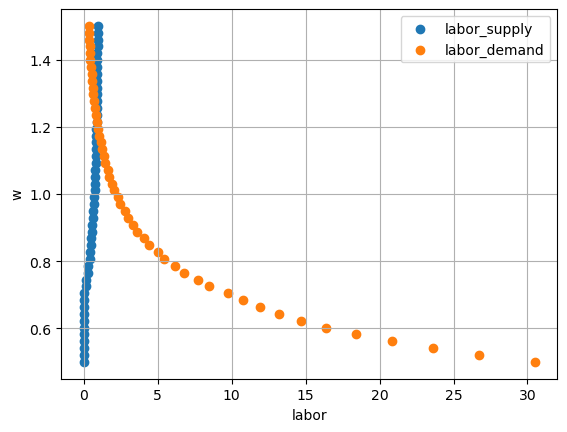

In [32]:
# Plot
plt.scatter(labor_supply,wgrid,label="labor_supply")
plt.scatter(labor_demand,wgrid,label="labor_demand")
# plt.title('labor market with r=0.082')
plt.ylabel('w')
plt.xlabel('labor')
plt.legend()
plt.grid(True)

In [99]:
from tqdm import tqdm

def capital_curve(rmin, rmax, rgrid_number):
    rgrid = np.linspace(rmin, rmax, rgrid_number)
    a_supply = np.zeros(rgrid_number)
    a_demand = np.zeros(rgrid_number)
    for i in tqdm(range(rgrid_number)):
        r0 = rgrid[i]
        w = w_update(r0)
        a_supply[i],a_demand[i],l_supply,l_demand=capital_and_labor(w,r0) #labor 只是为了占位
    return rgrid, a_supply, a_demand

rgrid, capital_supply, capital_demand = capital_curve(
    rmin=0.03, rmax=0.082, rgrid_number=20
)


  0%|          | 0/20 [00:00<?, ?it/s]

w= 1.5 r=, 0.03 labor supply= 0.8598834308834062 labor demand= 0.8324589464595518 res_l= 0.02742448442385448
w= 0.5 r=, 0.03 labor supply= 0.0 labor demand= 58.46412099681936 res_l= -58.46412099681936
w= 1.0 r=, 0.03 labor supply= 0.40280159887494715 labor demand= 5.087493133444777 res_l= -4.68469153456983
w= 1.25 r=, 0.03 labor supply= 0.7223350278169626 labor demand= 1.9351961269106446 res_l= -1.212861099093682
w= 1.375 r=, 0.03 labor supply= 0.8172249984871616 labor demand= 1.2248841402200215 res_l= -0.4076591417328599
w= 1.4375 r=, 0.03 labor supply= 0.8401422780481855 labor demand= 1.00710327278927 res_l= -0.1669609947410844
w= 1.46875 r=, 0.03 labor supply= 0.8599136460666138 labor demand= 0.8925990250295942 res_l= -0.032685378962980405
w= 1.484375 r=, 0.03 labor supply= 0.8598834308834059 labor demand= 0.8620284200083977 res_l= -0.0021449891249918362
w= 1.4921875 r=, 0.03 labor supply= 0.8598834308834058 labor demand= 0.8470759728373691 res_l= 0.012807458046036668
w= 1.48828125 

  5%|▌         | 1/20 [00:34<11:03, 34.91s/it]

w= 1.5 r=, 0.032736842105263154 labor supply= 0.8770330558592114 labor demand= 0.7580247832497894 res_l= 0.11900827260942204
w= 0.5 r=, 0.032736842105263154 labor supply= 0.0 labor demand= 56.00449102306381 res_l= -56.00449102306381
w= 1.0 r=, 0.032736842105263154 labor supply= 0.40280589585820015 labor demand= 4.874073690369003 res_l= -4.471267794510803
w= 1.25 r=, 0.032736842105263154 labor supply= 0.7591979448101462 labor demand= 1.7700171465157095 res_l= -1.0108192017055633
w= 1.375 r=, 0.032736842105263154 labor supply= 0.8172573175667672 labor demand= 1.1730930321615078 res_l= -0.3558357145947406
w= 1.4375 r=, 0.032736842105263154 labor supply= 0.8402070941448113 labor demand= 0.964083772228012 res_l= -0.12387667808320069
w= 1.46875 r=, 0.032736842105263154 labor supply= 0.8599644710262869 labor demand= 0.8545957320163896 res_l= 0.0053687390098973164
w= 1.453125 r=, 0.032736842105263154 labor supply= 0.8599857717937782 labor demand= 0.8853472374803609 res_l= -0.025361465686582707

 10%|█         | 2/20 [01:08<10:16, 34.27s/it]

w= 1.5 r=, 0.03547368421052632 labor supply= 0.8771227973873725 labor demand= 0.7261985093503024 res_l= 0.15092428803707014
w= 0.5 r=, 0.03547368421052632 labor supply= 0.0 labor demand= 53.718120671246545 res_l= -53.718120671246545
w= 1.0 r=, 0.03547368421052632 labor supply= 0.4918761103636888 labor demand= 4.474632270273846 res_l= -3.982756159910157
w= 1.25 r=, 0.03547368421052632 labor supply= 0.7592090983016352 labor demand= 1.6977597349508395 res_l= -0.9385506366492044
w= 1.375 r=, 0.03547368421052632 labor supply= 0.8402754866418085 labor demand= 1.0715826491220772 res_l= -0.23130716248026872
w= 1.4375 r=, 0.03547368421052632 labor supply= 0.8600366181955315 labor demand= 0.8798497174612827 res_l= -0.019813099265751255
w= 1.46875 r=, 0.03547368421052632 labor supply= 0.860021601814774 labor demand= 0.8191564667929201 res_l= 0.04086513502185396
w= 1.453125 r=, 0.03547368421052632 labor supply= 0.8600366181955309 labor demand= 0.8487076071754084 res_l= 0.011329011020122515
w= 1.44

 15%|█▌        | 3/20 [01:41<09:34, 33.80s/it]

w= 1.5 r=, 0.03821052631578947 labor supply= 0.877167383992849 labor demand= 0.6969963446939111 res_l= 0.18017103929893785
w= 0.5 r=, 0.03821052631578947 labor supply= 0.0 labor demand= 51.58764161376258 res_l= -51.58764161376258
w= 1.0 r=, 0.03821052631578947 labor supply= 0.49187880332054995 labor demand= 4.297422335537027 res_l= -3.805543532216477
w= 1.25 r=, 0.03821052631578947 labor supply= 0.7592249309327528 labor demand= 1.6302767527975632 res_l= -0.8710518218648104
w= 1.375 r=, 0.03821052631578947 labor supply= 0.8403077086055265 labor demand= 1.028737934028895 res_l= -0.1884302254233684
w= 1.4375 r=, 0.03821052631578947 labor supply= 0.8600818849463324 labor demand= 0.8444946409127599 res_l= 0.015587244033572478
w= 1.40625 r=, 0.03821052631578947 labor supply= 0.8600902701826195 labor demand= 0.9085803274847204 res_l= -0.048490057302100875
w= 1.421875 r=, 0.03821052631578947 labor supply= 0.8600818849463334 labor demand= 0.8758270373246945 res_l= -0.01574515237836105
w= 1.4296

 20%|██        | 4/20 [02:14<08:54, 33.43s/it]

w= 1.5 r=, 0.040947368421052635 labor supply= 0.8920510861099945 labor demand= 0.6360480334002229 res_l= 0.25600305270977164
w= 0.5 r=, 0.040947368421052635 labor supply= 0.0 labor demand= 49.59717631189178 res_l= -49.59717631189178
w= 1.0 r=, 0.040947368421052635 labor supply= 0.49188007206145146 labor demand= 4.131886579097934 res_l= -3.640006507036482
w= 1.25 r=, 0.040947368421052635 labor supply= 0.7905813257726843 labor demand= 1.4954964220098714 res_l= -0.7049150962371872
w= 1.375 r=, 0.040947368421052635 labor supply= 0.8403237175593897 labor demand= 0.9889161003334606 res_l= -0.14859238277407083
w= 1.4375 r=, 0.040947368421052635 labor supply= 0.8601102863202144 labor demand= 0.8116528702740042 res_l= 0.04845741604621012
w= 1.40625 r=, 0.040947368421052635 labor supply= 0.8601155474053728 labor demand= 0.8732847160571728 res_l= -0.013169168651800067
w= 1.421875 r=, 0.040947368421052635 labor supply= 0.8601102863202147 labor demand= 0.8417667730133064 res_l= 0.01834351330690831


 25%|██▌       | 5/20 [02:47<08:19, 33.30s/it]

w= 1.5 r=, 0.04368421052631579 labor supply= 0.8920836142360571 labor demand= 0.6118808069898959 res_l= 0.2802028072461612
w= 0.5 r=, 0.04368421052631579 labor supply= 0.0 labor demand= 47.73509707380026 res_l= -47.73509707380026
w= 1.0 r=, 0.04368421052631579 labor supply= 0.565717569142333 labor demand= 3.8048251808835003 res_l= -3.2391076117411672
w= 1.25 r=, 0.04368421052631579 labor supply= 0.7905869387135803 labor demand= 1.4393264681563338 res_l= -0.6487395294427535
w= 1.375 r=, 0.04368421052631579 labor supply= 0.8601369593835148 labor demand= 0.9056512437679411 res_l= -0.045514284384426396
w= 1.4375 r=, 0.04368421052631579 labor supply= 0.8772443562506613 labor demand= 0.7424910879337379 res_l= 0.13475326831692347
w= 1.40625 r=, 0.04368421052631579 labor supply= 0.8601343447226207 labor demand= 0.8403190377617277 res_l= 0.019815306960893064
w= 1.390625 r=, 0.04368421052631579 labor supply= 0.8601343447226197 labor demand= 0.8722062855377134 res_l= -0.012071940815093662
w= 1.39

 30%|███       | 6/20 [03:21<07:46, 33.33s/it]

w= 1.5 r=, 0.046421052631578946 labor supply= 0.8921017781350283 labor demand= 0.5893538618548411 res_l= 0.30274791628018727
w= 0.5 r=, 0.046421052631578946 labor supply= 0.0 labor demand= 45.989307609627744 res_l= -45.989307609627744
w= 1.0 r=, 0.046421052631578946 labor supply= 0.5657182351090444 labor demand= 3.6657865357382855 res_l= -3.100068300629241
w= 1.25 r=, 0.046421052631578946 labor supply= 0.7905916933564837 labor demand= 1.3866605970195853 res_l= -0.5960689036631016
w= 1.375 r=, 0.046421052631578946 labor supply= 0.8601476007360527 labor demand= 0.8724321497457603 res_l= -0.012284549009707657
w= 1.4375 r=, 0.046421052631578946 labor supply= 0.877257412549119 labor demand= 0.7152238600227045 res_l= 0.1620335525264145
w= 1.40625 r=, 0.046421052631578946 labor supply= 0.8601448412563202 labor demand= 0.8094979721966791 res_l= 0.05064686905964111
w= 1.390625 r=, 0.046421052631578946 labor supply= 0.860146301298508 labor demand= 0.8401983715881076 res_l= 0.01994792971040038
w=

 35%|███▌      | 7/20 [03:54<07:13, 33.31s/it]

w= 1.5 r=, 0.04915789473684211 labor supply= 0.9050426620634133 labor demand= 0.5388358169546624 res_l= 0.3662068451087509
w= 0.5 r=, 0.04915789473684211 labor supply= 0.0 labor demand= 44.3498846399751 res_l= -44.3498846399751
w= 1.0 r=, 0.04915789473684211 labor supply= 0.5657185296750099 labor demand= 3.535183581696476 res_l= -2.969465052021466
w= 1.25 r=, 0.04915789473684211 labor supply= 0.8173783687578856 labor demand= 1.2749614044270343 res_l= -0.4575830356691487
w= 1.375 r=, 0.04915789473684211 labor supply= 0.8601528892891763 labor demand= 0.8412896865713475 res_l= 0.01886320271782882
w= 1.3125 r=, 0.04915789473684211 labor supply= 0.8403586603342887 labor demand= 1.0322564289379883 res_l= -0.19189776860369956
w= 1.34375 r=, 0.04915789473684211 labor supply= 0.8601539755828793 labor demand= 0.9082797876761926 res_l= -0.048125812093313236
w= 1.359375 r=, 0.04915789473684211 labor supply= 0.8601534640477497 labor demand= 0.8739503837044089 res_l= -0.01379691965665919
w= 1.367187

 40%|████      | 8/20 [04:28<06:41, 33.47s/it]

w= 1.5 r=, 0.051894736842105264 labor supply= 0.9050488794591737 labor demand= 0.5200515140929323 res_l= 0.3849973653662414
w= 0.5 r=, 0.051894736842105264 labor supply= 0.0 labor demand= 42.80781263504777 res_l= -42.80781263504777
w= 1.0 r=, 0.051894736842105264 labor supply= 0.5657186713324487 labor demand= 3.4123036800761044 res_l= -2.8465850087436557
w= 1.25 r=, 0.051894736842105264 labor supply= 0.8173795313436211 labor demand= 1.2306287925606252 res_l= -0.4132492612170041
w= 1.375 r=, 0.051894736842105264 labor supply= 0.8601558032453916 labor demand= 0.8120151632313802 res_l= 0.048140640014011415
w= 1.3125 r=, 0.051894736842105264 labor supply= 0.8403605063938561 labor demand= 0.9963532466276743 res_l= -0.15599274023381826
w= 1.34375 r=, 0.051894736842105264 labor supply= 0.8601562837275972 labor demand= 0.8766816843327592 res_l= -0.016525400605161944
w= 1.359375 r=, 0.051894736842105264 labor supply= 0.8601560574687811 labor demand= 0.8435431716541647 res_l= 0.01661288581461639

 45%|████▌     | 9/20 [05:02<06:09, 33.55s/it]

w= 1.5 r=, 0.05463157894736842 labor supply= 0.9050518694188496 labor demand= 0.5023792464512012 res_l= 0.4026726229676484
w= 0.5 r=, 0.05463157894736842 labor supply= 0.0 labor demand= 41.35498852177134 res_l= -41.35498852177134
w= 1.0 r=, 0.05463157894736842 labor supply= 0.5657187346240721 labor demand= 3.2965149377023213 res_l= -2.730796203078249
w= 1.25 r=, 0.05463157894736842 labor supply= 0.8173801303617267 labor demand= 1.1888620814427233 res_l= -0.3714819510809966
w= 1.375 r=, 0.05463157894736842 labor supply= 0.877273124754749 labor demand= 0.7457280958396065 res_l= 0.13154502891514241
w= 1.3125 r=, 0.05463157894736842 labor supply= 0.8403614575693863 labor demand= 0.9625327904711515 res_l= -0.12217133290176518
w= 1.34375 r=, 0.05463157894736842 labor supply= 0.8601574729908362 labor demand= 0.8469199116420424 res_l= 0.013237561348793836
w= 1.328125 r=, 0.05463157894736842 labor supply= 0.8601574729908363 labor demand= 0.8805907015719029 res_l= -0.020433228581066554
w= 1.3359

 50%|█████     | 10/20 [05:37<05:39, 33.98s/it]

w= 1.5 r=, 0.05736842105263158 labor supply= 0.9163454352691867 labor demand= 0.4598831675480938 res_l= 0.4564622677210929
w= 0.5 r=, 0.05736842105263158 labor supply= 0.0 labor demand= 39.98417031240179 res_l= -39.98417031240179
w= 1.0 r=, 0.05736842105263158 labor supply= 0.6272863426024075 labor demand= 3.0481775113074243 res_l= -2.4208911687050167
w= 1.25 r=, 0.05736842105263158 labor supply= 0.8173803637625019 labor demand= 1.149454117406179 res_l= -0.3320737536436771
w= 1.375 r=, 0.05736842105263158 labor supply= 0.8772736737781704 labor demand= 0.7210051610369161 res_l= 0.1562685127412543
w= 1.3125 r=, 0.05736842105263158 labor supply= 0.8601579559533279 labor demand= 0.8856552804195845 res_l= -0.025497324466256632
w= 1.34375 r=, 0.05736842105263158 labor supply= 0.860157914374958 labor demand= 0.8188438413411607 res_l= 0.041314073033797305
w= 1.328125 r=, 0.05736842105263158 labor supply= 0.8601579363740955 labor demand= 0.8513981536488702 res_l= 0.008759782725225373
w= 1.32031

 55%|█████▌    | 11/20 [06:12<05:08, 34.32s/it]

w= 1.5 r=, 0.06010526315789474 labor supply= 0.9163458607163891 labor demand= 0.444982543527436 res_l= 0.47136331718895313
w= 0.5 r=, 0.06010526315789474 labor supply= 0.0 labor demand= 38.68891477846538 res_l= -38.68891477846538
w= 1.0 r=, 0.06010526315789474 labor supply= 0.6272863485869917 labor demand= 2.94943694057823 res_l= -2.322150591991238
w= 1.25 r=, 0.06010526315789474 labor supply= 0.8403619457559677 labor demand= 1.0595075212677367 res_l= -0.21914557551176905
w= 1.375 r=, 0.06010526315789474 labor supply= 0.8772738535056854 labor demand= 0.6976475797593438 res_l= 0.17962627374634166
w= 1.3125 r=, 0.06010526315789474 labor supply= 0.8601580752404279 labor demand= 0.8569645873778104 res_l= 0.003193487862617417
w= 1.28125 r=, 0.06010526315789474 labor supply= 0.840361939250026 labor demand= 0.9757933715727307 res_l= -0.13543143232270471
w= 1.296875 r=, 0.06010526315789474 labor supply= 0.860158079544363 labor demand= 0.8918671372980189 res_l= -0.031709057753655956
w= 1.304687

 60%|██████    | 12/20 [06:45<04:32, 34.02s/it]

w= 1.5 r=, 0.0628421052631579 labor supply= 0.9163459882140745 labor demand= 0.4308866835478209 res_l= 0.48545930466625364
w= 0.5 r=, 0.0628421052631579 labor supply= 0.0 labor demand= 37.46343202563928 res_l= -37.46343202563928
w= 1.0 r=, 0.0628421052631579 labor supply= 0.6272863502725868 labor demand= 2.856013351121423 res_l= -2.2287270008488362
w= 1.25 r=, 0.0628421052631579 labor supply= 0.8403619656941527 labor demand= 1.025947305051271 res_l= -0.1855853393571184
w= 1.375 r=, 0.0628421052631579 labor supply= 0.8921247335610348 labor demand= 0.6414309535403079 res_l= 0.25069378002072695
w= 1.3125 r=, 0.0628421052631579 labor supply= 0.8601581057662282 labor demand= 0.8298198420006027 res_l= 0.03033826376562554
w= 1.28125 r=, 0.0628421052631579 labor supply= 0.860158108303756 labor demand= 0.8992254265086573 res_l= -0.03906731820490128
w= 1.296875 r=, 0.0628421052631579 labor supply= 0.8601581067123254 labor demand= 0.8636168785718369 res_l= -0.003458771859511489
w= 1.3046875 r=, 0

 65%|██████▌   | 13/20 [07:19<03:57, 33.97s/it]

w= 1.5 r=, 0.06557894736842106 labor supply= 0.9262389114512634 labor demand= 0.3946734332993526 res_l= 0.5315654781519108
w= 0.5 r=, 0.06557894736842106 labor supply= 0.0 labor demand= 36.30251368152011 res_l= -36.30251368152011
w= 1.0 r=, 0.06557894736842106 labor supply= 0.6272863502731305 labor demand= 2.767511242889061 res_l= -2.1402248926159304
w= 1.25 r=, 0.06557894736842106 labor supply= 0.8403619694776193 labor demand= 0.9941552119252947 res_l= -0.15379324244767534
w= 1.375 r=, 0.06557894736842106 labor supply= 0.8921247468073917 labor demand= 0.6215541665607323 res_l= 0.2705705802466595
w= 1.3125 r=, 0.06557894736842106 labor supply= 0.8772739225419399 labor demand= 0.7644173734913028 res_l= 0.11285654905063713
w= 1.28125 r=, 0.06557894736842106 labor supply= 0.8601581143671151 labor demand= 0.8713601650474494 res_l= -0.011202050680334308
w= 1.296875 r=, 0.06557894736842106 labor supply= 0.8601581128695224 labor demand= 0.8368550562189809 res_l= 0.023303056650541443
w= 1.2890

 70%|███████   | 14/20 [07:54<03:25, 34.30s/it]

w= 1.5 r=, 0.06831578947368422 labor supply= 0.9262389155143551 labor demand= 0.38270291459211125 res_l= 0.5435360009222439
w= 0.5 r=, 0.06831578947368422 labor supply= 0.0 labor demand= 35.20145424114742 res_l= -35.20145424114742
w= 1.0 r=, 0.06831578947368422 labor supply= 0.6789060907131013 labor demand= 2.5653139100463593 res_l= -1.886407819333258
w= 1.25 r=, 0.06831578947368422 labor supply= 0.8403619702112364 labor demand= 0.9640023684848872 res_l= -0.12364039827365081
w= 1.375 r=, 0.06831578947368422 labor supply= 0.892124746088193 labor demand= 0.6027023690924959 res_l= 0.2894223769956972
w= 1.3125 r=, 0.06831578947368422 labor supply= 0.877273922541938 labor demand= 0.7412325127044321 res_l= 0.1360414098375059
w= 1.28125 r=, 0.06831578947368422 labor supply= 0.8601581139515067 labor demand= 0.8449317228932416 res_l= 0.015226391058265065
w= 1.265625 r=, 0.06831578947368422 labor supply= 0.8601581143671131 labor demand= 0.8802061360585824 res_l= -0.020048021691469353
w= 1.273437

 75%|███████▌  | 15/20 [08:28<02:51, 34.36s/it]

w= 1.5 r=, 0.07105263157894737 labor supply= 0.9262389164315026 labor demand= 0.37133679269559633 res_l= 0.5549021237359062
w= 0.5 r=, 0.07105263157894737 labor supply= 0.0 labor demand= 34.55463358263425 res_l= -34.55463358263425
w= 1.0 r=, 0.07105263157894737 labor supply= 0.6789060907078676 labor demand= 2.4891251696485277 res_l= -1.8102190789406603
w= 1.25 r=, 0.07105263157894737 labor supply= 0.8601581142858044 labor demand= 0.8901722512044412 res_l= -0.030014136918636858
w= 1.375 r=, 0.07105263157894737 labor supply= 0.8921247466077993 labor demand= 0.5848023582000136 res_l= 0.3073223884077857
w= 1.3125 r=, 0.07105263157894737 labor supply= 0.8772739224142535 labor demand= 0.7192182212618715 res_l= 0.158055701152382
w= 1.28125 r=, 0.07105263157894737 labor supply= 0.8601581142517759 labor demand= 0.8198376038207841 res_l= 0.04032051043099183
w= 1.265625 r=, 0.07105263157894737 labor supply= 0.8601581142644629 labor demand= 0.8540643865083557 res_l= 0.00609372775610717
w= 1.257812

 80%|████████  | 16/20 [09:03<02:17, 34.29s/it]

w= 1.5 r=, 0.07378947368421053 labor supply= 0.9262389167317394 labor demand= 0.3605328467878877 res_l= 0.5657060699438516
w= 0.5 r=, 0.07378947368421053 labor supply= 0.0 labor demand= 33.40507000303917 res_l= -33.40507000303917
w= 1.0 r=, 0.07378947368421053 labor supply= 0.6789060907123924 labor demand= 2.4167047446976793 res_l= -1.737798653985287
w= 1.25 r=, 0.07378947368421053 labor supply= 0.8601581143470314 labor demand= 0.8642729291269923 res_l= -0.004114814779960896
w= 1.375 r=, 0.07378947368421053 labor supply= 0.9050538105561747 labor demand= 0.5383895861786523 res_l= 0.36666422437752244
w= 1.3125 r=, 0.07378947368421053 labor supply= 0.8772739225065034 labor demand= 0.6982927603129153 res_l= 0.17898116219358806
w= 1.28125 r=, 0.07378947368421053 labor supply= 0.8772739225138697 labor demand= 0.7566975334108659 res_l= 0.12057638910300383
w= 1.265625 r=, 0.07378947368421053 labor supply= 0.8601581143445486 labor demand= 0.8292156128160619 res_l= 0.030942501528486654
w= 1.2578

 85%|████████▌ | 17/20 [09:39<01:44, 34.85s/it]

w= 1.5 r=, 0.07652631578947369 labor supply= 0.9349313361696819 labor demand= 0.33046709958730264 res_l= 0.6044642365823794
w= 0.5 r=, 0.07652631578947369 labor supply= 0.0 labor demand= 32.30950966545143 res_l= -32.30950966545143
w= 1.0 r=, 0.07652631578947369 labor supply= 0.6789060907130263 labor demand= 2.3477947637246275 res_l= -1.668888673011601
w= 1.25 r=, 0.07652631578947369 labor supply= 0.8601581143631853 labor demand= 0.8396290285098151 res_l= 0.02052908585337021
w= 1.125 r=, 0.07652631578947369 labor supply= 0.7905963909317016 labor demand= 1.3801142039057457 res_l= -0.589517812974044
w= 1.1875 r=, 0.07652631578947369 labor supply= 0.8403619705416682 labor demand= 1.046772637419455 res_l= -0.20641066687778686
w= 1.21875 r=, 0.07652631578947369 labor supply= 0.8403619705404981 labor demand= 0.9599508415090561 res_l= -0.11958887096855797
w= 1.234375 r=, 0.07652631578947369 labor supply= 0.860158114363186 labor demand= 0.8755825494104309 res_l= -0.015424435047244889
w= 1.24218

 90%|█████████ | 18/20 [10:14<01:10, 35.10s/it]

w= 1.5 r=, 0.07926315789473684 labor supply= 0.9349313361345291 labor demand= 0.32122854592178446 res_l= 0.6137027902127445
w= 0.5 r=, 0.07926315789473684 labor supply= 0.0 labor demand= 32.24445961094405 res_l= -32.24445961094405
w= 1.0 r=, 0.07926315789473684 labor supply= 0.6789060907130848 labor demand= 2.2821597019425224 res_l= -1.6032536112294375
w= 1.25 r=, 0.07926315789473684 labor supply= 0.8601581143600783 labor demand= 0.8161563195973547 res_l= 0.04400179476272359
w= 1.125 r=, 0.07926315789473684 labor supply= 0.8173804534147444 labor demand= 1.279071202420849 res_l= -0.46169074900610463
w= 1.1875 r=, 0.07926315789473684 labor supply= 0.8403619705411525 labor demand= 1.0175090119218648 res_l= -0.17714704138071236
w= 1.21875 r=, 0.07926315789473684 labor supply= 0.8601581143626993 labor demand= 0.8880238475629831 res_l= -0.02786573320028385
w= 1.234375 r=, 0.07926315789473684 labor supply= 0.8601581143615411 labor demand= 0.8511047221462196 res_l= 0.009053392215321532
w= 1.22

 95%|█████████▌| 19/20 [10:49<00:34, 34.98s/it]

w= 1.5 r=, 0.082 labor supply= 0.9349312984216277 labor demand= 0.3124208806645981 res_l= 0.6225104177570295
w= 0.5 r=, 0.082 labor supply= 0.0 labor demand= 30.50095483326742 res_l= -30.50095483326742
w= 1.0 r=, 0.082 labor supply= 0.7224094412783365 labor demand= 2.120650179018302 res_l= -1.3982407377399655
w= 1.25 r=, 0.082 labor supply= 0.8772739187936974 labor demand= 0.7545995846024429 res_l= 0.12267433419125451
w= 1.125 r=, 0.082 labor supply= 0.8173804530818775 labor demand= 1.2439997313541904 res_l= -0.42661927827231294
w= 1.1875 r=, 0.082 labor supply= 0.8403619693458634 labor demand= 0.9896094524689875 res_l= -0.14924748312312408
w= 1.21875 r=, 0.082 labor supply= 0.8601581119802185 labor demand= 0.8636747181664066 res_l= -0.003516606186188098
w= 1.234375 r=, 0.082 labor supply= 0.8601581113537382 labor demand= 0.8277679023240043 res_l= 0.032390209029733885
w= 1.2265625 r=, 0.082 labor supply= 0.8601581116852093 labor demand= 0.845473555826458 res_l= 0.01468455585875128
w= 1

100%|██████████| 20/20 [11:24<00:00, 34.24s/it]


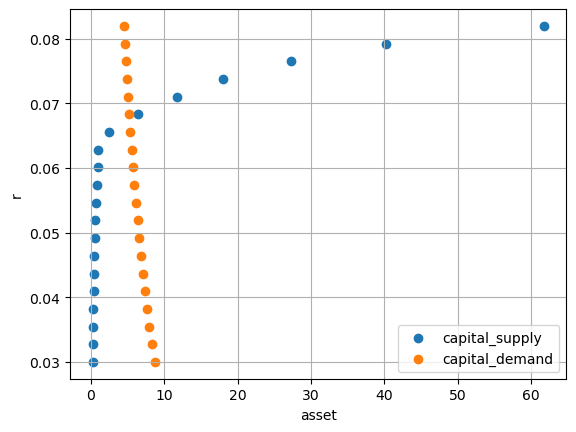

In [100]:

# Plot
plt.scatter(capital_supply,rgrid,label="capital_supply")
plt.scatter(capital_demand,rgrid,label="capital_demand")
# plt.title('capital market with w=0.8375')
plt.ylabel('r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

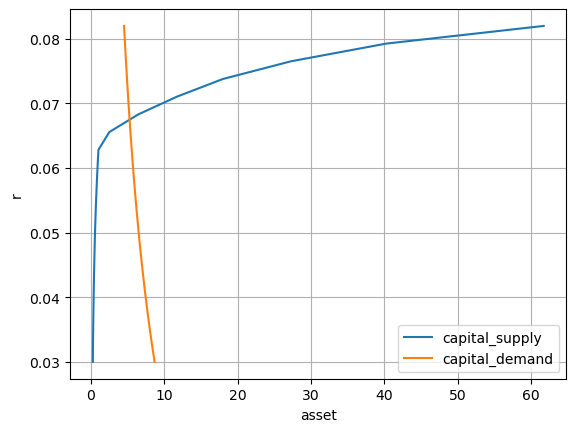

In [101]:
# Plot
plt.plot(capital_supply,rgrid,label="capital_supply")
plt.plot(capital_demand,rgrid,label="capital_demand")
# plt.title('capital market with w=0.8375')
plt.ylabel('r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

In [102]:
rgrid

array([0.03      , 0.03273684, 0.03547368, 0.03821053, 0.04094737,
       0.04368421, 0.04642105, 0.04915789, 0.05189474, 0.05463158,
       0.05736842, 0.06010526, 0.06284211, 0.06557895, 0.06831579,
       0.07105263, 0.07378947, 0.07652632, 0.07926316, 0.082     ])

## Iteration

In [103]:
# nested bisection 
def rw_iteration(tol):
    rmin= 0.06557895
    rmax=0.06831579
    r0=1/2*(rmin+rmax)
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        w = w_update(r0)
        res_k = equilibrium_k(w,r0)
        if res_k < 0:
            rmin=r0
        else:
            rmax=r0
        r0 = 1/2*(rmin+rmax)
        error = np.abs(rmax-rmin)
        count = count + 1
        print('rmin=',rmin,'rmax=',rmax,'r=',r0,'iteration times=',count)
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return r0 

In [104]:
start_time = timeit.default_timer()
r_eq = rw_iteration(1e-5)
print("The time difference is :", timeit.default_timer() - start_time)

w= 1.5 r=, 0.06694737 labor supply= 0.9262389144604298 labor demand= 0.3886098175450225 res_l= 0.5376290969154074
w= 0.5 r=, 0.06694737 labor supply= 0.0 labor demand= 35.74477728780164 res_l= -35.74477728780164
w= 1.0 r=, 0.06694737 labor supply= 0.6789060907130661 labor demand= 2.6049086939914368 res_l= -1.9260026032783708
w= 1.25 r=, 0.06694737 labor supply= 0.8403619699483675 labor demand= 0.9788814342164053 res_l= -0.13851946426803774
w= 1.375 r=, 0.06694737 labor supply= 0.8921247453602607 labor demand= 0.6120048908353881 res_l= 0.28011985452487254
w= 1.3125 r=, 0.06694737 labor supply= 0.8772739216161581 labor demand= 0.7526732053642619 res_l= 0.12460071625189628
w= 1.28125 r=, 0.06694737 labor supply= 0.8601581143671031 labor demand= 0.8579729635722502 res_l= 0.0021851507948529303
w= 1.265625 r=, 0.06694737 labor supply= 0.8601581136228387 labor demand= 0.8937918402130245 res_l= -0.03363372659018582
w= 1.2734375 r=, 0.06694737 labor supply= 0.8601581136228387 labor demand= 0.87

In [105]:
w_eq = w_update(r_eq)

w= 1.5 r=, 0.0673669831640625 labor supply= 0.9262389149566107 labor demand= 0.38678212985649657 res_l= 0.5394567851001142
w= 0.5 r=, 0.0673669831640625 labor supply= 0.0 labor demand= 35.57666479744333 res_l= -35.57666479744333
w= 1.0 r=, 0.0673669831640625 labor supply= 0.6789060907130718 labor demand= 2.592657460752209 res_l= -1.913751370039137
w= 1.25 r=, 0.0673669831640625 labor supply= 0.8403619700721241 labor demand= 0.9742776225845443 res_l= -0.1339156525124202
w= 1.375 r=, 0.0673669831640625 labor supply= 0.8921247456611197 labor demand= 0.609126547214881 res_l= 0.28299819844623864
w= 1.3125 r=, 0.0673669831640625 labor supply= 0.8772739217179942 labor demand= 0.7491332816826681 res_l= 0.1281406400353261
w= 1.28125 r=, 0.0673669831640625 labor supply= 0.8601581143671042 labor demand= 0.8539378022194429 res_l= 0.006220312147661278
w= 1.265625 r=, 0.0673669831640625 labor supply= 0.8601581137775735 labor demand= 0.8895882159621504 res_l= -0.02943010218457698
w= 1.2734375 r=, 0.0

In [106]:
equilibrium_l(w_eq,r_eq)

w= 1.2784652709960938 r=, 0.0673669831640625 labor supply= 0.8601581137047082 labor demand= 0.8601536854748624 res_l= 4.428229845809817e-06


4.428229845809817e-06

In [107]:
equilibrium_k(w_eq,r_eq)

w= 1.2784652709960938 r=, 0.0673669831640625 capital supply= 5.286293284979713 capital demand= 5.286074773600964 res_k= 0.00021851137874939752


0.00021851137874939752

In [112]:
from tqdm import tqdm

def labor_curve(n_a, wmin, wmax, wgrid_number,r):
    wgrid = np.linspace(wmin, wmax, wgrid_number)
    l_supply = np.zeros(wgrid_number)
    l_demand = np.zeros(wgrid_number)
    for i in tqdm(range(wgrid_number)):
        w0 = wgrid[i]
        capital_supply,capital_demand,l_supply[i],l_demand[i]=capital_and_labor(w0,r) #capital 只是为了占位
    return wgrid, l_supply, l_demand

wgrid, labor_supply, labor_demand = labor_curve(
    n_a=n_k, wmin=0.5, wmax=1.5, wgrid_number=50,r=r_eq
)


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


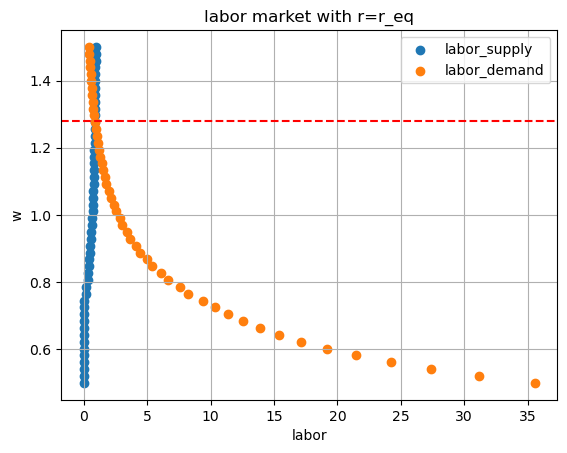

In [120]:
# Plot
plt.scatter(labor_supply,wgrid,label="labor_supply")
plt.scatter(labor_demand,wgrid,label="labor_demand")
plt.title('labor market with r=r_eq')
plt.ylabel('w')
plt.xlabel('labor')
plt.axhline(w_eq,ls='--',color='r')
plt.legend()
plt.grid(True)

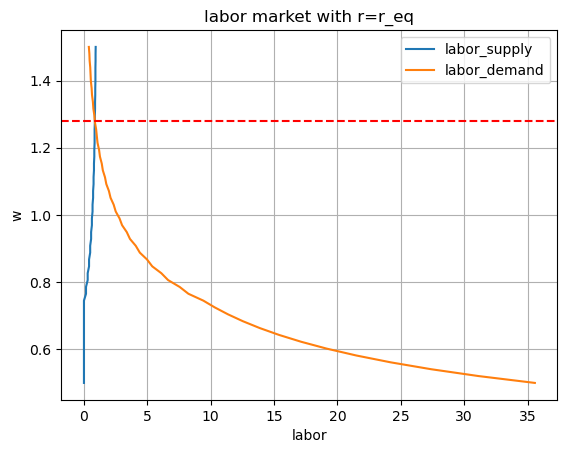

In [121]:
# Plot
plt.plot(labor_supply,wgrid,label="labor_supply")
plt.plot(labor_demand,wgrid,label="labor_demand")
plt.title('labor market with r=r_eq')
plt.ylabel('w')
plt.axhline(w_eq,ls='--',color='r')
plt.xlabel('labor')
plt.legend()
plt.grid(True)

In [115]:
from tqdm import tqdm

def capital_curve(n_a, rmin, rmax, rgrid_number,w):
    rgrid = np.linspace(rmin, rmax, rgrid_number)
    a_supply = np.zeros(rgrid_number)
    a_demand = np.zeros(rgrid_number)
    for i in tqdm(range(rgrid_number)):
        r0 = rgrid[i]
        a_supply[i],a_demand[i],l_supply,l_demand=capital_and_labor(w,r0) #labor 只是为了占位
    return rgrid, a_supply, a_demand

rgrid, capital_supply, capital_demand = capital_curve(
    n_a=n_k, rmin=0.03, rmax=0.082, rgrid_number=50,w=w_eq
)


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


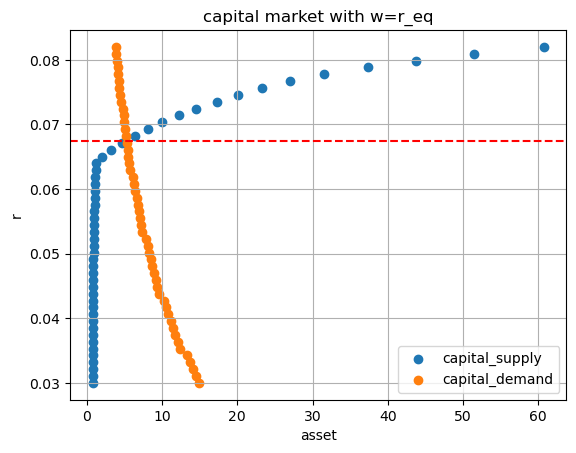

In [119]:
# Plot
plt.scatter(capital_supply,rgrid,label="capital_supply")
plt.scatter(capital_demand,rgrid,label="capital_demand")
plt.title('capital market with w=r_eq')
plt.ylabel('r')
plt.xlabel('asset')
plt.axhline(r_eq,ls='--',color='r')
plt.legend()
plt.grid(True)

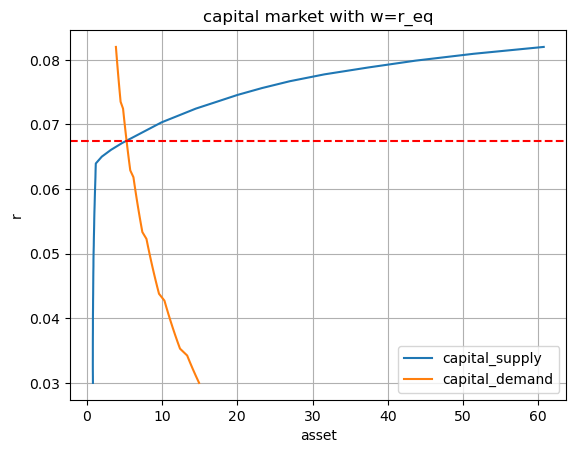

In [125]:
# Plot
plt.plot(capital_supply,rgrid,label="capital_supply")
plt.plot(capital_demand,rgrid,label="capital_demand")
plt.title('capital market with w=r_eq')
plt.ylabel('r')
plt.axhline(r_eq,ls='--',color='r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

## goods market recheck

In [139]:
def goods(w,r):
    R = r+delta
    V0 = np.zeros((n_k, n_z))
    V_new,g,state_entrepreneur=V_iteration(V0,1e-7,w,r)
    state_worker=np.ones((n_k , n_z))-state_entrepreneur
    Q=transQ_sparse(g)
    psi0 = np.ones((n_k * n_z))/(n_k * n_z)
    ss=sparse_stationary_distribution_iteration(Q,psi0,10e-5)
    tmp = ss.reshape((n_k, n_z))
    a_dist=capital_marginal(ss)
    z_dist=state_marginal(ss)
    goods_demand_joint = np.zeros((n_k, n_z))
    goods_supply_joint = np.zeros((n_k, n_z))
    capital_joint = np.zeros((n_k,n_z))        
    for i_k in range(n_k):
        for i_z in range(n_z):
            k = ((R / alpha / zgrid[i_z]) * (w * alpha / R / theta) ** theta) ** (1 / (alpha + theta - 1))
            l = k * (theta / alpha) * (R / w)
            goods_demand_joint[i_k,i_z]=(state_entrepreneur[i_k,i_z]*budget_entrepreneur(i_z,k,l,kgrid[i_k], g[i_k,i_z], w, r)+state_worker[i_k,i_z]*budget_worker(kgrid[i_k], g[i_k,i_z], w, r))*tmp[i_k,i_z]
            goods_supply_joint[i_k,i_z]=state_entrepreneur[i_k,i_z]*(zgrid[i_z]*(k**alpha)*(l**theta))*tmp[i_k,i_z]
            capital_joint[i_k,i_z]=state_entrepreneur[i_k,i_z]*k*tmp[i_k,i_z]
    goods_demand = np.sum(goods_demand_joint)
    goods_supply = np.sum(goods_supply_joint)
    capital = np.sum(capital_joint)
    return goods_supply,goods_demand,capital

In [140]:
goods_supply,goods_demand,capital=goods(w_eq,r_eq)

In [141]:
print('goods supply=',goods_supply,'goods demand=',goods_demand,'capital supply=',capital)

goods supply= 2.2442379889773636 goods demand= 1.932168152755912 capital supply= 5.286293284979713


In [142]:
goods_supply-goods_demand-delta*capital

-0.005107760877331224